In [94]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt
import tables


from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, ProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

from sklearn.metrics import f1_score

print(torch.cuda.device_count())

#np.random.seed(seed=1)
#L.seed_everything(seed=1, workers=True)

1


In [95]:
folder_path = '/eos/user/c/castaned/NanoAOD_mixed/forEstephania4/'
h5_files = [f for f in os.listdir(folder_path) if f.endswith('2.h5')]
print(h5_files)

['ntuple_merged_12.h5', 'ntuple_merged_2.h5']


In [96]:
import h5py

## List to store sets of keys per file
#key_sets = []

#for file_name in h5_files:
#    file_path = os.path.join(folder_path, file_name)
#    with h5py.File(file_path, "r") as f:
#        keys = set(f.keys())  # Get the set of top-level keys
#        key_sets.append(keys)

# Compute intersection of all key sets
# if key_sets:
 #    common_keys = set.intersection(*key_sets)

#     if common_keys:
#         # Use the first file to get shape and dtype
#         first_file_path = os.path.join(folder_path, h5_files[0])
#         with h5py.File(first_file_path, "r") as f:
 #            #print("Common variables with shape and dtype (from first file):")
#             for key in sorted(common_keys):
#                 if isinstance(f[key], h5py.Dataset):
#                     shape = f[key].shape
#                     dtype = f[key].dtype
#                     print(f"Dataset: {key}, Shape: {f[key].shape}, Type: {f[key].dtype}")
#                 else:
#                     print(f"{key} is not a dataset.")
#     else:
#         print("No common variables found across all files.")
# else:
#     print("No .h5 files found in the folder.")

### Define the list of variables from the h5 file to use as features, spectator and labels

In [97]:
features = [
            'D_Dr_Z',
            'D_Lep1Z_pt',
            'D_Lep2Z_pt',
            'D_Lep1Z_eta',
            'D_Lep2Z_eta',
            'D_Lep1Z_phi',
            'D_Lep2Z_phi',
            'D_Lep3W_pt',
            'D_Lep3W_eta',
            'D_Lep3W_phi',
            'D_Sum_mass',
            'D_Sum_pt',
            'D_Wmass',
            'D_Zmass',
            'D_nlep',
            'MET_pt',
            'MET_phi',
            'D_ptZ',
            'D_mu1ip3d',
            'D_mu2ip3d',
            'D_mu3ip3d'
           ]

# spectators to define mass/pT window
# spectators = ['fj_sdmass',
#               'fj_pt']

# 2 labels: QCD or Hbb
labels = ['Dataset_ID']

nfeatures = len(features)
# nspectators = len(spectators)
nlabels = len(labels)

In [98]:
len(features)

21

In [99]:
def get_all_features_labels(folder_path):
    feature_list = []
    dataset_id_list = []
    label_list = []

    h5_files = [f for f in os.listdir(folder_path) if f.endswith('2.h5')]

    for file_name in h5_files:
        file_path = os.path.join(folder_path, file_name)
        with tables.open_file(file_path, 'r') as h5file:
            nevents = getattr(h5file.root, features[0]).shape[0]

            feature_array = np.zeros((nevents, nfeatures))
            label_array = np.zeros((nevents, 2))

            # Load features
            for i, feat in enumerate(features):
                feature_array[:, i] = getattr(h5file.root, feat)[:]

            # Load labels
            for i, label in enumerate(labels):
                dataset_id_array = getattr(h5file.root, label)[:]  # Load Dataset_ID
                label_array[:, 0] = np.isin(dataset_id_array, [1]).astype(int)  # Background
                label_array[:, 1] = np.isin(dataset_id_array, [3]).astype(int)  # Signal

        feature_list.append(feature_array)
        dataset_id_list.append(dataset_id_array)
        label_list.append(label_array)

    # Concatenate all arrays
    all_features = np.vstack(feature_list)
    all_dataset_ids = np.concatenate(dataset_id_list)
    all_labels = np.vstack(label_list)

    return all_features, all_dataset_ids, all_labels

In [100]:
# load training file
feature_array, dataset_id_array, label_array = get_all_features_labels(folder_path)

print(feature_array.shape)
print(dataset_id_array.shape)
print(label_array.shape)

(100000, 21)
(100000,)
(100000, 2)


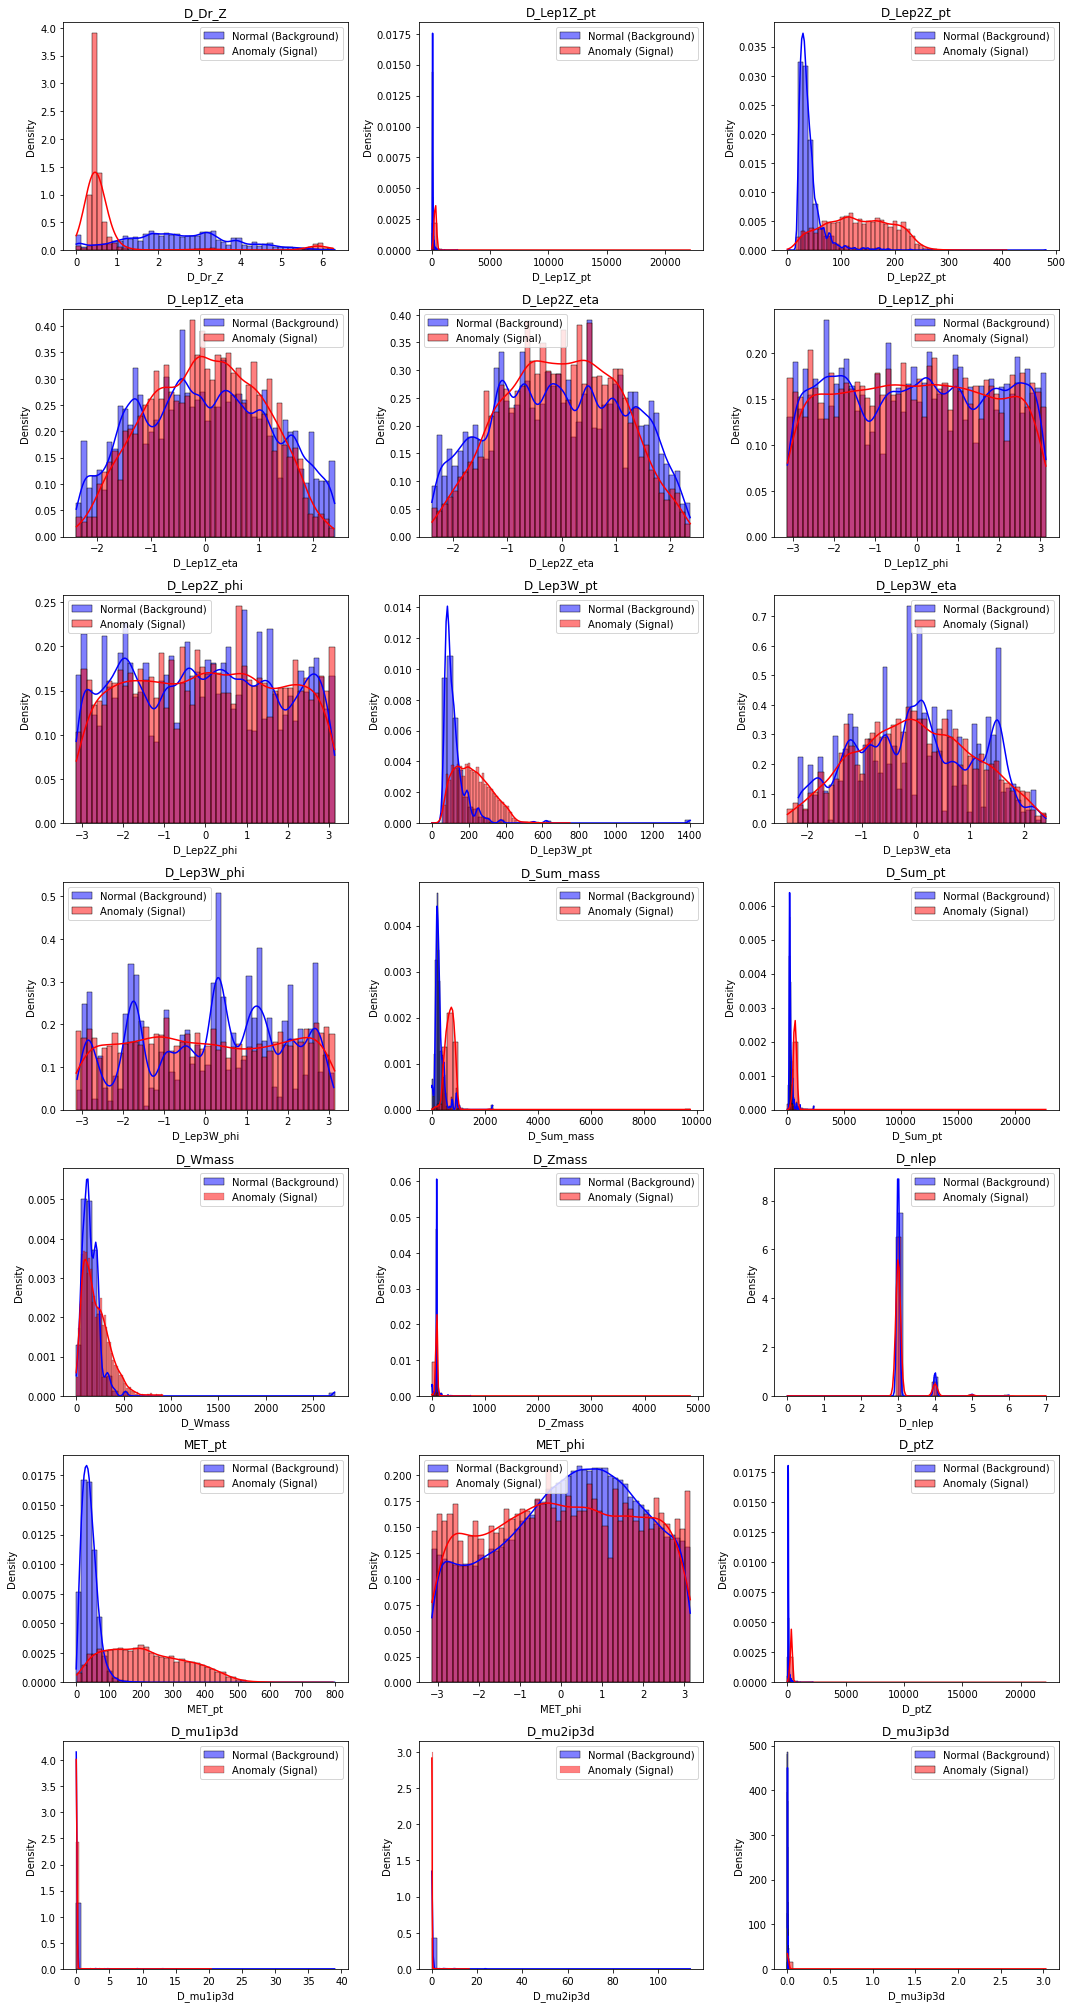

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_comparison(all_features, all_labels, feature_names):
    nfeatures = len(feature_names)
    ncols = 3
    nrows = (nfeatures + ncols - 1) // ncols

    # Get boolean masks for background and signal
    mask_bg = all_labels[:, 0] == 1
    mask_sig = all_labels[:, 1] == 1

    plt.figure(figsize=(5 * ncols, 4 * nrows))

    for i, feat in enumerate(feature_names):
        plt.subplot(nrows, ncols, i + 1)

        # Plot histograms with KDE overlay
        sns.histplot(all_features[mask_bg, i], color='blue', label='Normal (Background)', stat='density', kde=True, bins=50, alpha=0.5)
        sns.histplot(all_features[mask_sig, i], color='red', label='Anomaly (Signal)', stat='density', kde=True, bins=50, alpha=0.5)

        plt.title(feat)
        plt.xlabel(feat)
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_feature_comparison(feature_array,label_array, features)


In [102]:

# Get background and signal indices
background_indices = np.where(dataset_id_array == 1)[0]
signal_indices = np.where(dataset_id_array == 3)[0]

# Count background events
background_count = len(background_indices)

# Calculate number of signal events for a 1:1000 ratio
target_signal_count = max(1, background_count // 800)  # Ensure at least 1 event

print(f"Background count: {background_count}")
print(f"Target signal count (1:100): {target_signal_count}")

# Downsample signal events
np.random.seed(1)
selected_signal_indices = np.random.choice(signal_indices, size=target_signal_count, replace=True)

# Combine indices
final_indices = np.concatenate([background_indices, selected_signal_indices])
np.random.shuffle(final_indices)

# Filter arrays
feature_array = feature_array[final_indices]
label_array = label_array[final_indices]
dataset_id_array = dataset_id_array[final_indices]

print("New shapes after downsampling:")
print("Features:", feature_array.shape)
print("Labels:", label_array.shape)
print("Dataset IDs:", dataset_id_array.shape)


Background count: 95041
Target signal count (1:100): 118
New shapes after downsampling:
Features: (95159, 21)
Labels: (95159, 2)
Dataset IDs: (95159,)


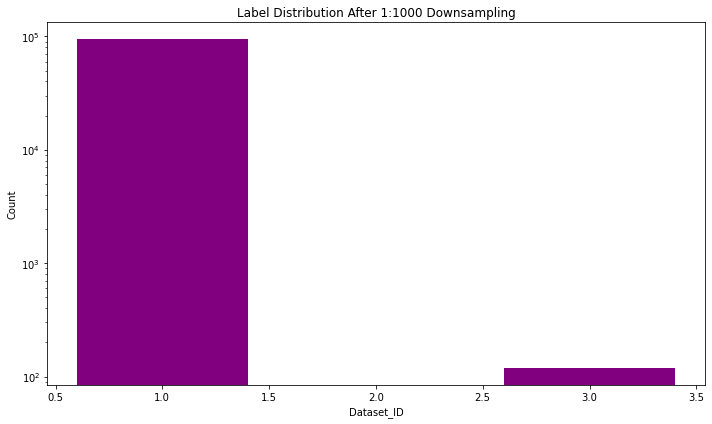

In [103]:

unique_labels, counts = np.unique(dataset_id_array, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='purple')
plt.yscale('log')
plt.xlabel('Dataset_ID')
plt.ylabel('Count')
plt.title('Label Distribution After 1:1000 Downsampling')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [104]:
feature_array[0]
feature_array[0].size

21

In [105]:
np.unique(dataset_id_array)

array([1., 3.], dtype=float32)

[1. 3.]
[95041   118]


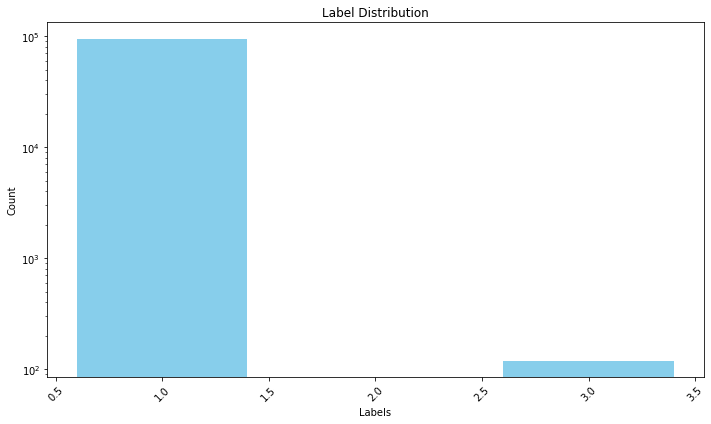

In [106]:

unique_labels, counts = np.unique(dataset_id_array, return_counts=True)
print(unique_labels)
print(counts)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.yscale('log')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [107]:
# Mapping the labels to 0-1
dataset_id_array

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [108]:
label_array

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [109]:
binary_labels = np.where(dataset_id_array <= 2, 0, 1)

In [110]:
# Divide train and validation+test
X_train, X_test, y_train, y_test= train_test_split(feature_array, binary_labels, test_size=0.15, random_state=42, shuffle=True, stratify = binary_labels)

# Divide validation+test in validation and test
#X_valid, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

In [111]:
X_test.size

299754

### Load the data (numpy.array) into a DatasetLoad (Tensor)

In [112]:
class SensorDataset(Dataset):

    def __init__(self, dataset: np.array):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return torch.FloatTensor(self.dataset[index])

## Autoencoder
#### AE: Pytorch Lightning Model Implementation
Implementation of a plain Autoencoder

In [113]:
#scaler = MinMaxScaler()

#train = scaler.fit_transform(X_train)
#test = scaler.transform(X_test)


In [114]:
# Example data
#X = train

# Clip to 1st and 99th percentile to reduce extreme outliers
#lower, upper = np.percentile(X, [1, 99])
#train = np.clip(X, lower, upper)
#test = scaler.transform(X_test)


In [135]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = scaler.fit_transform(X_train)
test = scaler.transform(X_test)

In [136]:
# Optional: Apply log1p transform to selected features (same indices in both sets)
#log_transform_features = [
#    'D_Lep1Z_pt', 'D_Lep2Z_pt', 'D_Lep3W_pt',
#    'D_Sum_pt', 'D_Wmass', 'MET_pt', 'D_ptZ'
#]
#log_indices = [features.index(f) for f in log_transform_features]

#X_train[:, log_indices] = np.log1p(X_train[:, log_indices])
#X_test[:, log_indices] = np.log1p(X_test[:, log_indices])

# Revisa si hay NaN o infinitos en los datos
#print("X_train contiene NaN o inf antes del escalado:", not np.isfinite(X_train).all())
#print("X_test contiene NaN o inf antes del escalado:", not np.isfinite(X_test).all())

# Reemplaza NaN e infinitos por valores finitos razonables
#X_train = np.nan_to_num(X_train, nan=0.0, posinf=np.finfo(np.float64).max, neginf=-np.finfo(np.float64).max)
#X_test = np.nan_to_num(X_test, nan=0.0, posinf=np.finfo(np.float64).max, neginf=-np.finfo(np.float64).max)


# StandardScaler equivalent of:
# scaler = RobustScaler()
#scaler = StandardScaler()
#train = scaler.fit_transform(X_train)
#test = scaler.transform(X_test)

In [137]:
#from sklearn.preprocessing import RobustScaler

#scaler = RobustScaler()
#train = scaler.fit_transform(X_train)
#test = scaler.transform(X_test)

In [138]:
test.size

299754

In [139]:
class Autoencoder(L.LightningModule):
    def __init__(self, in_dim=21, latent_dim=4, dropout_rate=0.3, noise_std=0.1):
        super().__init__()
        self.save_hyperparameters()

        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

        # Encoder: 21 -> 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(16, 8),
            nn.LeakyReLU(0.01),

            nn.Linear(8, latent_dim)  # bottleneck (4)
        )

        # Decoder: 4 -> 8 -> 16 -> 21
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(8, 16),
            nn.LeakyReLU(0.01),

            nn.Linear(16, in_dim)  # reconstruction (21)
        )

        self.encoder.apply(init_weights)
        self.decoder.apply(init_weights)

        self.training_losses = []
        self.validation_losses = []

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def compute_loss(self, x, x_reconstructed):
        return F.mse_loss(x_reconstructed, x)

    def training_step(self, batch, batch_idx):
        clean_input = batch
        noisy_input = clean_input + self.hparams.noise_std * torch.randn_like(clean_input)
        output = self(noisy_input)
        loss = self.compute_loss(clean_input, output)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        # Usa get() para evitar KeyError cuando aún no está agregada la métrica
        tl = self.trainer.callback_metrics.get('train_loss')
        if tl is not None:
            self.training_losses.append(tl.item())

    def validation_step(self, batch, batch_idx):
        output = self(batch)
        loss = self.compute_loss(batch, output)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        vl = self.trainer.callback_metrics.get('val_loss')
        if vl is not None:
            self.validation_losses.append(vl.item())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=3, verbose=True
            ),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


#### PyTorch Progress Bar Implementation

In [140]:
class SimpleProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.bar = None
        self.enabled = True

    def on_train_epoch_start(self, trainer, pl_module):
        if self.enabled:
            self.bar = tqdm(total=self.total_train_batches,
                            desc=f"Epoch {trainer.current_epoch+1}",
                            position=0,
                            leave=True)
            self.running_loss = 0.0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if self.bar:
            self.running_loss += outputs['loss'].item()
            self.bar.update(1)
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}')
            # self.bar.set_postfix(self.get_metrics(trainer, pl_module))

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        if self.bar:
            val_loss = trainer.logged_metrics['val_loss'].item()
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}', val_loss=f'{val_loss:.4f}')
            self.bar.close()
            self.bar = None

    def disable(self):
        self.bar = None
        self.enabled = False

In [141]:
torch.set_float32_matmul_precision("high")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [142]:

model = Autoencoder(in_dim=train.shape[1])

batch_size = 64  # increase if GPU allows

ae_train, ae_valid = train_test_split(train, test_size=0.20, random_state=1, shuffle=True)
ae_train_ds, ae_val_ds, ae_test_ds = SensorDataset(ae_train), SensorDataset(ae_valid), SensorDataset(test)
ae_tdl = DataLoader(ae_train_ds, batch_size=batch_size, num_workers=4)
ae_vdl = DataLoader(ae_val_ds, batch_size=batch_size, num_workers=4)
ae_testdl = DataLoader(ae_test_ds, batch_size=batch_size, num_workers=4)

es = EarlyStopping(
    monitor='val_loss',    # métrica a monitorear
    min_delta=0.00001,        # mínimo cambio para considerar mejora
    patience=10,            # cuántas épocas esperar sin mejora antes de parar
    verbose=True,
    mode='min'             # queremos minimizar val_loss
)
#EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=10)
cp = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb = SimpleProgressBar()

trainer = L.Trainer(
    callbacks=[pb, es, cp],
    max_epochs=40,
    logger=False,
    enable_checkpointing=True,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",  # or "bf16-mixed" (best on A100)
    gradient_clip_val=1.0  # added for stability
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [143]:

trainer.fit(model, train_dataloaders=ae_tdl, val_dataloaders=ae_vdl)


/eos/user/c/castaned/.local/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /eos/home-i04/c/castaned/VAE_training/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 524    | train
1 | decoder | Sequential | 541    | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
Epoch 1: 100%|██████████| 1012/1012 [00:09<00:00, 111.50it/s, loss=1.0810, val_loss=0.8193]

### Loss curve

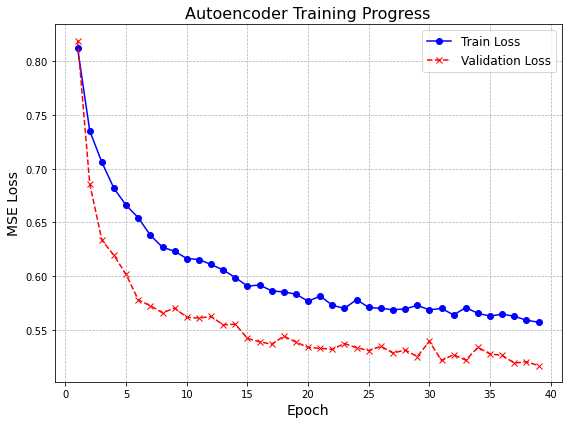

In [153]:
# Ensure both training and validation losses have the same length
train_losses = model.training_losses[1:]
val_losses = model.validation_losses[1:]

# Truncate the longer list to match the shorter list
min_len = min(len(train_losses), len(val_losses))
train_losses = train_losses[:min_len]
val_losses = val_losses[:min_len]

# Adjust the epoch range accordingly
epochs = range(1, len(train_losses) + 1)

# Plotting the loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='b', linestyle='-', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='r', linestyle='--', marker='x')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE Loss', fontsize=14)
plt.title('Autoencoder Training Progress', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Save the plot as an image
plt.savefig('autoencoder_training_progress.png')  # You can specify the path if needed

# Show the plot
plt.show()



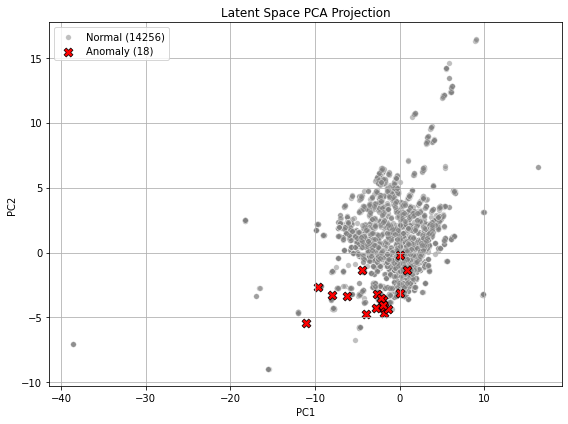

Normal samples: 14256
Anomaly samples: 18


In [154]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []

with torch.no_grad():
    for batch in ae_testdl:
        batch = batch.to(device)
        z = model.encoder(batch)
        latent_vectors.append(z.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()

# Ensure y_test is numpy array and aligned with latent vectors
if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().numpy()

y_test_aligned = y_test[:latent_vectors.shape[0]]

# Map binary labels to strings for plotting
label_names = np.array(['Normal', 'Anomaly'])
y_labels = label_names[y_test_aligned]

# PCA projection
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

# Prepare DataFrame for plotting
df = pd.DataFrame({
    'PC1': latent_pca[:, 0],
    'PC2': latent_pca[:, 1],
    'Label': y_labels
})

# Count samples per label
counts = df['Label'].value_counts().to_dict()
normal_label = f"Normal ({counts.get('Normal', 0)})"
anomaly_label = f"Anomaly ({counts.get('Anomaly', 0)})"

# Plot
plt.figure(figsize=(8,6))

# Normal points
sns.scatterplot(
    data=df[df['Label'] == 'Normal'],
    x='PC1', y='PC2',
    label=normal_label,
    color='gray',
    alpha=0.5,
    s=30
)

# Anomaly points
sns.scatterplot(
    data=df[df['Label'] == 'Anomaly'],
    x='PC1', y='PC2',
    label=anomaly_label,
    color='red',
    marker='X',
    s=80,
    edgecolor='black'
)

plt.title('Latent Space PCA Projection')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('autoencoder_latentspace_disa.png')  # You can specify the path if needed


plt.show()

# Optional: print counts
print(f"Normal samples: {counts.get('Normal', 0)}")
print(f"Anomaly samples: {counts.get('Anomaly', 0)}")



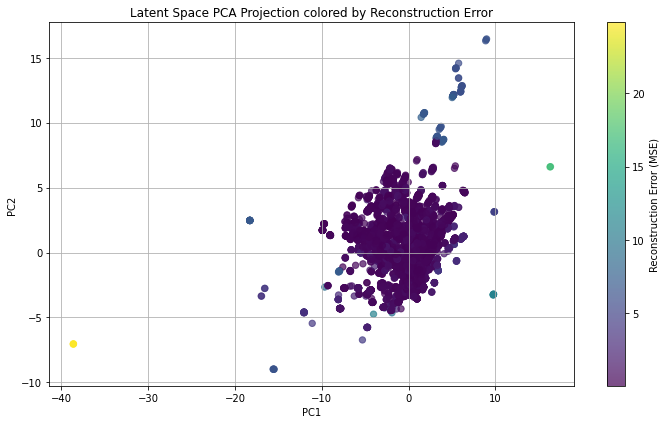

In [155]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []
reconstruction_errors = []
inputs_all = []

with torch.no_grad():
    for batch in ae_testdl:
        batch = batch.to(device)
        z = model.encoder(batch)
        outputs = model.decoder(z)
        
        # Compute per-sample MSE error (assumes batch shape [B, features])
        batch_errors = F.mse_loss(outputs, batch, reduction='none')
        batch_errors = batch_errors.mean(dim=1)  # mean over features
        
        latent_vectors.append(z.cpu())
        reconstruction_errors.append(batch_errors.cpu())
        inputs_all.append(batch.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
reconstruction_errors = torch.cat(reconstruction_errors, dim=0).numpy()

# Align labels
if isinstance(y_test, torch.Tensor):
    y_test_np = y_test.cpu().numpy()
else:
    y_test_np = y_test
y_test_aligned = y_test_np[:latent_vectors.shape[0]]

# PCA projection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

# Build DataFrame with PCA coords, labels, and error
label_names = np.array(['Normal', 'Anomaly'])
y_labels = label_names[y_test_aligned]

df = pd.DataFrame({
    'PC1': latent_pca[:, 0],
    'PC2': latent_pca[:, 1],
    'Label': y_labels,
    'ReconError': reconstruction_errors
})

# Plot: PCA scatter colored by reconstruction error
plt.figure(figsize=(10,6))
scatter = plt.scatter(df['PC1'], df['PC2'], c=df['ReconError'], cmap='viridis', alpha=0.7, s=40)
plt.colorbar(scatter, label='Reconstruction Error (MSE)')
plt.title('Latent Space PCA Projection colored by Reconstruction Error')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()

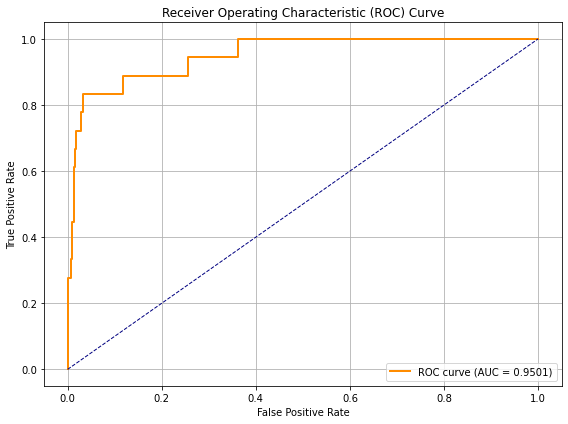

In [156]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_aligned, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



📌 Best threshold (Youden's J): 1.4229
   TPR at best threshold: 0.8333
   FPR at best threshold: 0.0325


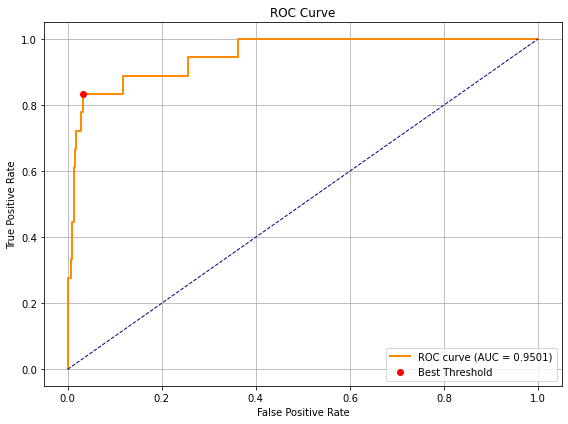

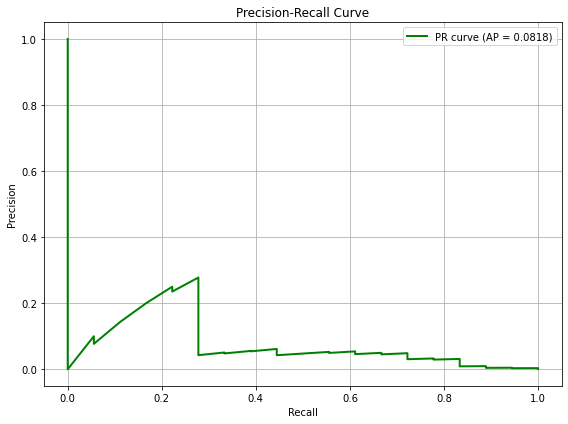

In [157]:
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score
)

# --- ROC Curve ---
fpr, tpr, thresholds_roc = roc_curve(y_test_aligned, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Find best threshold using Youden's J statistic
j_scores = tpr - fpr
best_j_idx = np.argmax(j_scores)
best_threshold = thresholds_roc[best_j_idx]

print(f"\n📌 Best threshold (Youden's J): {best_threshold:.4f}")
print(f"   TPR at best threshold: {tpr[best_j_idx]:.4f}")
print(f"   FPR at best threshold: {fpr[best_j_idx]:.4f}")

# --- ROC Plot ---
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal
plt.scatter(fpr[best_j_idx], tpr[best_j_idx], c='red', label='Best Threshold', zorder=5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, thresholds_pr = precision_recall_curve(y_test_aligned, reconstruction_errors)
ap_score = average_precision_score(y_test_aligned, reconstruction_errors)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [158]:
from sklearn.metrics import classification_report, confusion_matrix

# --- Step 1: Apply best threshold to classify ---
predictions = (reconstruction_errors >= best_threshold).astype(int)  # 1 = anomaly

# --- Step 2: Confusion matrix ---
cm = confusion_matrix(y_test_aligned, predictions)
print("\n🔍 Confusion Matrix:")
print(cm)

# Optional: display as DataFrame for readability
cm_df = pd.DataFrame(cm, index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
print("\n🔍 Confusion Matrix (Labeled):")
print(cm_df)

# --- Step 3: Classification report ---
print("\n📋 Classification Report (at best threshold):")
print(classification_report(y_test_aligned, predictions, target_names=['Normal', 'Anomaly']))


🔍 Confusion Matrix:
[[13792   464]
 [    3    15]]

🔍 Confusion Matrix (Labeled):
                Predicted Normal  Predicted Anomaly
Actual Normal              13792                464
Actual Anomaly                 3                 15

📋 Classification Report (at best threshold):
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98     14256
     Anomaly       0.03      0.83      0.06        18

    accuracy                           0.97     14274
   macro avg       0.52      0.90      0.52     14274
weighted avg       1.00      0.97      0.98     14274



In [159]:
# --- Definir strict_threshold (precisión ≥ 0.6) ---
target_precision = 0.60
# OJO: precision y recall tienen len = len(thresholds) + 1
prec_mask = precision[:-1] >= target_precision
if np.any(prec_mask):
    # toma el primer umbral que alcanza la precisión deseada
    strict_threshold = thresholds[prec_mask][0]
else:
    # respaldo: si no se alcanza esa precisión, usa el de Youden
    strict_threshold = best_threshold



🔍 Confusion Matrix (Manual Threshold = 5.0):
[[14143   113]
 [   12     6]]

                 Predicted Normal  Predicted Anomaly
Actual Normal              14143                113
Actual Anomaly                12                  6

📋 Classification Report (Manual Threshold = 5.0):
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     14256
     Anomaly       0.05      0.33      0.09        18

    accuracy                           0.99     14274
   macro avg       0.52      0.66      0.54     14274
weighted avg       1.00      0.99      0.99     14274



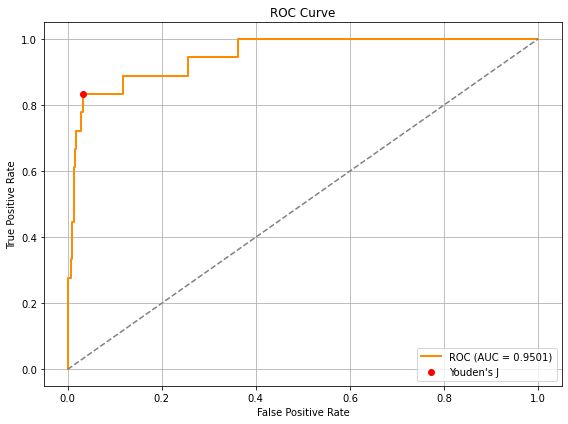

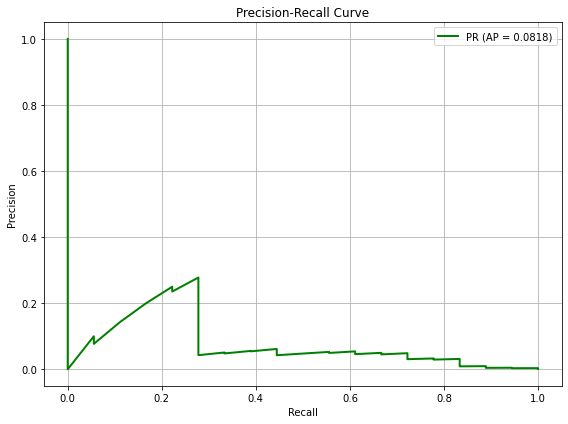

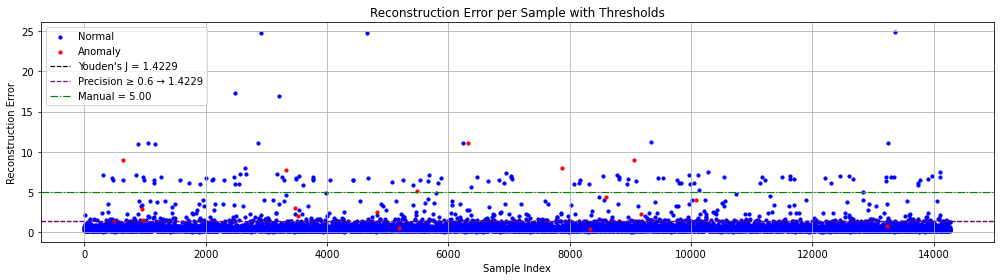

In [160]:
# --- Manual threshold ---
manual_threshold = 5.0
predictions_manual = (reconstruction_errors >= manual_threshold).astype(int)

# --- Evaluation function remains the same ---
def evaluate_predictions(y_true, y_pred, name):
    print(f"\n🔍 Confusion Matrix ({name}):")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    cm_df = pd.DataFrame(cm, index=['Actual Normal', 'Actual Anomaly'],
                              columns=['Predicted Normal', 'Predicted Anomaly'])
    print("\n", cm_df)
    print(f"\n📋 Classification Report ({name}):")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

# --- Evaluate manual threshold ---
evaluate_predictions(y_test_aligned, predictions_manual, f"Manual Threshold = {manual_threshold}")

# --- ROC Curve (same as before) ---
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(fpr[best_j_idx], tpr[best_j_idx], c='red', label="Youden's J", zorder=5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curve (same as before) ---
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Reconstruction Error per Sample with All Thresholds ---
plt.figure(figsize=(14, 4))

# Masks (assuming defined earlier)
normal_mask = y_test_aligned == 0
anomaly_mask = y_test_aligned == 1

plt.scatter(np.arange(len(reconstruction_errors))[normal_mask], 
            reconstruction_errors[normal_mask], 
            c='blue', label='Normal', s=10)

plt.scatter(np.arange(len(reconstruction_errors))[anomaly_mask], 
            reconstruction_errors[anomaly_mask], 
            c='red', label='Anomaly', s=10)

# Add all three thresholds
plt.axhline(best_threshold, color='black', linestyle='--', linewidth=1.2,
            label=f"Youden's J = {best_threshold:.4f}")
plt.axhline(strict_threshold, color='purple', linestyle='--', linewidth=1.2,
            label=f'Precision ≥ 0.6 → {strict_threshold:.4f}')
plt.axhline(manual_threshold, color='green', linestyle='-.', linewidth=1.2,
            label=f'Manual = {manual_threshold:.2f}')

plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error per Sample with Thresholds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




🔍 Confusion Matrix (Manual Threshold = 5.0):
[[14143   113]
 [   12     6]]

                 Predicted Normal  Predicted Anomaly
Actual Normal              14143                113
Actual Anomaly                12                  6

📋 Classification Report (Manual Threshold = 5.0):
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     14256
     Anomaly       0.05      0.33      0.09        18

    accuracy                           0.99     14274
   macro avg       0.52      0.66      0.54     14274
weighted avg       1.00      0.99      0.99     14274



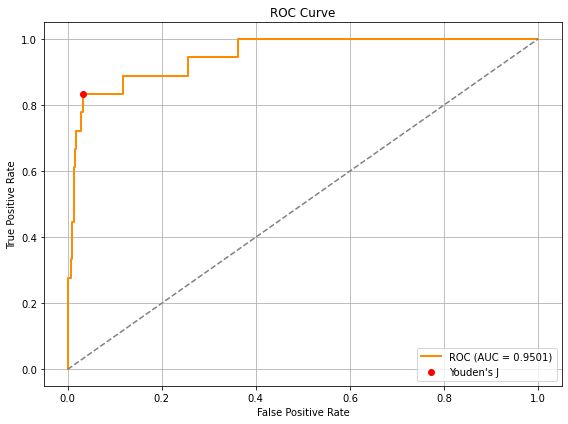

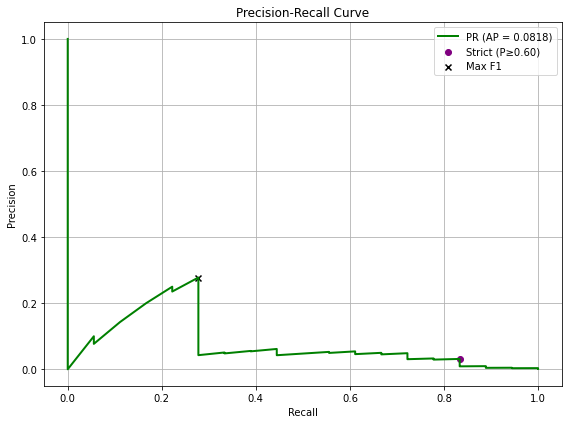

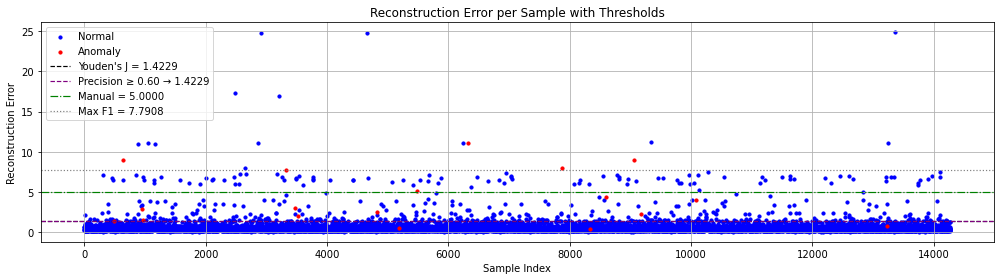

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

# =======================================================================
# REQUISITOS: define antes estos arrays con misma longitud (N,)
#   - reconstruction_errors: errores de reconstrucción (float)
#   - y_test_aligned: etiquetas 0=normal, 1=anomalía
# =======================================================================
assert len(reconstruction_errors) == len(y_test_aligned), "Longitudes no coinciden."
reconstruction_errors = np.asarray(reconstruction_errors).ravel()
y_test_aligned = np.asarray(y_test_aligned).ravel()

# --------------------- Curva ROC y Youden ------------------------------
fpr, tpr, roc_thresholds = roc_curve(y_test_aligned, reconstruction_errors)
roc_auc = auc(fpr, tpr)
youden = tpr - fpr
best_j_idx = int(np.argmax(youden))
best_threshold = roc_thresholds[best_j_idx]

# ----------------- Curva PR, AP y umbrales derivados -------------------
precision, recall, pr_thresholds = precision_recall_curve(y_test_aligned, reconstruction_errors)
ap_score = average_precision_score(y_test_aligned, reconstruction_errors)

# strict_threshold: precisión >= 0.60 con máxima recall
target_precision = 0.60
mask = precision[:-1] >= target_precision  # pr_thresholds se alinea con precision[:-1]/recall[:-1]
if np.any(mask):
    cand = np.where(mask)[0]
    best_cand = cand[np.argmax(recall[:-1][cand])]
    strict_threshold = pr_thresholds[best_cand]
else:
    strict_threshold = best_threshold  # respaldo si no se alcanza esa precisión

# (opcional) umbral que maximiza F1 en la curva PR
f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)
f1_idx = int(np.argmax(f1))
f1_threshold = pr_thresholds[f1_idx]

# -------------------- Umbral "manual" a utilizar -----------------------
# Por defecto mantenemos tu 5.0. Si prefieres automático, descomenta UNA línea:
manual_threshold = 5.0
# manual_threshold = strict_threshold    # precisión mínima 0.60
# manual_threshold = f1_threshold        # mejor F1 para la clase anomalía

# ----------------- Predicciones con el umbral manual -------------------
predictions_manual = (reconstruction_errors >= manual_threshold).astype(int)

# ---------------------- Función de evaluación --------------------------
def evaluate_predictions(y_true, y_pred, name):
    print(f"\n🔍 Confusion Matrix ({name}):")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    cm_df = pd.DataFrame(cm, index=['Actual Normal', 'Actual Anomaly'],
                              columns=['Predicted Normal', 'Predicted Anomaly'])
    print("\n", cm_df)
    print(f"\n📋 Classification Report ({name}):")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

# ------------------ Evaluación del umbral seleccionado -----------------
evaluate_predictions(y_test_aligned, predictions_manual, f"Manual Threshold = {manual_threshold}")

# ------------------------------- ROC -----------------------------------
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(fpr[best_j_idx], tpr[best_j_idx], c='red', label="Youden's J", zorder=5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------- Precision-Recall ---------------------------
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR (AP = {ap_score:.4f})')
# marcas (opcionales) para strict y F1
# ubicamos su recall/precision aproximando al umbral más cercano
def _nearest(arr, val): return int(np.argmin(np.abs(arr - val)))

# Para visualizar dónde caen strict y F1 en la curva PR
if len(pr_thresholds) > 0:
    s_idx = _nearest(pr_thresholds, strict_threshold) if 'strict_threshold' in locals() else None
    f_idx = _nearest(pr_thresholds, f1_threshold) if 'f1_threshold' in locals() else None
    if s_idx is not None:
        plt.scatter(recall[s_idx], precision[s_idx], marker='o', c='purple', label='Strict (P≥0.60)')
    if f_idx is not None:
        plt.scatter(recall[f_idx], precision[f_idx], marker='x', c='black', label='Max F1')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------- Errores de reconstrucción por muestra con umbrales -----------
plt.figure(figsize=(14, 4))

normal_mask = y_test_aligned == 0
anomaly_mask = y_test_aligned == 1
idx = np.arange(len(reconstruction_errors))

plt.scatter(idx[normal_mask], reconstruction_errors[normal_mask], c='blue', label='Normal', s=10)
plt.scatter(idx[anomaly_mask], reconstruction_errors[anomaly_mask], c='red',  label='Anomaly', s=10)

plt.axhline(best_threshold,   color='black',  linestyle='--', linewidth=1.2,
            label=f"Youden's J = {best_threshold:.4f}")
plt.axhline(strict_threshold, color='purple', linestyle='--', linewidth=1.2,
            label=f'Precision ≥ {target_precision:.2f} → {strict_threshold:.4f}')
plt.axhline(manual_threshold, color='green',  linestyle='-.', linewidth=1.2,
            label=f'Manual = {manual_threshold:.4f}')
plt.axhline(f1_threshold,     color='gray',   linestyle=':',  linewidth=1.2,
            label=f'Max F1 = {f1_threshold:.4f}')

plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error per Sample with Thresholds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
"""
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []
reconstruction_errors = []

with torch.no_grad():
    for batch in ae_testdl:
        batch = batch.to(device)
        z = model.encoder(batch)
        outputs = model.decoder(z)

        # MSE reconstruction error per sample
        batch_errors = F.mse_loss(outputs, batch, reduction='none').mean(dim=1)
        latent_vectors.append(z.cpu())
        reconstruction_errors.append(batch_errors.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
reconstruction_errors = torch.cat(reconstruction_errors, dim=0).numpy()

# Align y_test with latent_vectors
if isinstance(y_test, torch.Tensor):
    y_test = y_test.cpu().numpy()
y_test_aligned = y_test[:latent_vectors.shape[0]]
label_names = np.array(['Normal', 'Anomaly'])
y_labels = label_names[y_test_aligned]

# PCA projection
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

# Create DataFrame
df = pd.DataFrame({
    'PC1': latent_pca[:, 0],
    'PC2': latent_pca[:, 1],
    'Label': y_labels,
    'ReconError': reconstruction_errors
})

# Normalize reconstruction error for visual scaling (optional)
error_norm = (df['ReconError'] - df['ReconError'].min()) / (df['ReconError'].max() - df['ReconError'].min())
df['ErrorSize'] = 30 + 170 * error_norm  # scale size: 30–200

# Plot: color = label, size = reconstruction error
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='PC1', y='PC2',
    hue='Label',
    size='ErrorSize',
    sizes=(30, 200),
    alpha=0.7,
    palette={'Normal': 'gray', 'Anomaly': 'red'},
    edgecolor='black',
    legend='brief'
)

plt.title('Latent Space PCA: Color = Label, Size = Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: also print counts
counts = df['Label'].value_counts().to_dict()
print(f"Normal samples: {counts.get('Normal', 0)}")
print(f"Anomaly samples: {counts.get('Anomaly', 0)}")


In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test_aligned is the true labels and reconstruction_errors are the predicted scores
fpr, tpr, thresholds = roc_curve(y_test_aligned, reconstruction_errors)
roc_auc = auc(fpr, tpr)


In [ ]:
"""
# --- t-SNE visualization ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
latent_tsne = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], s=10, alpha=0.7)
plt.title('Latent Space t-SNE Projection')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.grid(True)
plt.show()

# --- KMeans clustering (on original latent vectors) ---
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_vectors)

# Plot clusters on PCA
plt.figure(figsize=(8,6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clusters (k={n_clusters}) on Latent Space PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

# Plot clusters on t-SNE
plt.figure(figsize=(8,6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clusters (k={n_clusters}) on Latent Space t-SNE')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.grid(True)
plt.show()

# --- Correlation heatmap ---
latent_df = pd.DataFrame(latent_vectors, columns=[f'latent_{i}' for i in range(latent_vectors.shape[1])])
input_df = pd.DataFrame(inputs, columns=[f'feature_{i}' for i in range(inputs.shape[1])])

corr_matrix = pd.concat([latent_df, input_df], axis=1).corr()
corr_latent_features = corr_matrix.loc[latent_df.columns, input_df.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_latent_features, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Latent Variables and Input Features")
plt.xlabel("Input Features")
plt.ylabel("Latent Variables")
plt.show()

In [ ]:
"""
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import animation

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

latent_vectors = []
inputs = []
recon_errors = []
time_steps = []  # Optional: fill if you have time info

# --- Inference Loop ---
with torch.no_grad():
    for i, batch in enumerate(ae_vdl):
        batch = batch.to(device)
        z = model.encoder(batch)
        recon = model.decoder(z)
        loss = torch.nn.functional.mse_loss(recon, batch, reduction='none')
        per_sample_mse = loss.view(loss.size(0), -1).mean(dim=1)

        latent_vectors.append(z.cpu())
        inputs.append(batch.cpu())
        recon_errors.append(per_sample_mse.cpu())
        time_steps.extend([i] * batch.size(0))  # Optional

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
inputs = torch.cat(inputs, dim=0).numpy()
recon_errors = torch.cat(recon_errors, dim=0).numpy()
time_steps = np.array(time_steps)  # Optional

# --- Scatter plot with reconstruction error ---
plt.figure(figsize=(8,6))
sc = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1],
                 c=recon_errors, cmap='viridis', s=15, alpha=0.8)
plt.colorbar(sc, label='Reconstruction Error (MSE)')
plt.title('Latent Space Colored by Reconstruction Error')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.grid(True)
plt.show()

# --- KMeans Clustering ---
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_vectors)

plt.figure(figsize=(8,6))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=clusters, cmap='tab10', s=15, alpha=0.8)
plt.colorbar(label='Cluster ID')
plt.title(f'KMeans Clustering (k={n_clusters}) in Latent Space')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.grid(True)
plt.show()

# --- Correlation Heatmap ---
latent_df = pd.DataFrame(latent_vectors, columns=[f'latent_{i}' for i in range(latent_vectors.shape[1])])
input_df = pd.DataFrame(inputs, columns=[f'feature_{i}' for i in range(inputs.shape[1])])

corr_matrix = pd.concat([latent_df, input_df], axis=1).corr()
corr_latent_features = corr_matrix.loc[latent_df.columns, input_df.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_latent_features, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Latent Variables and Input Features")
plt.xlabel("Input Features")
plt.ylabel("Latent Variables")
plt.tight_layout()
plt.show()


In [ ]:
"""
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Range of k values to try
k_range = range(2, 11)

best_k = None
best_score = -1
best_labels = None

for k in k_range:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(latent_vectors) + (k + 1) * 10])

    # Apply KMeans and compute silhouette scores
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_vectors)

    silhouette_avg = silhouette_score(latent_vectors, cluster_labels)
    sample_silhouette_values = silhouette_samples(latent_vectors, cluster_labels)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k
        best_labels = cluster_labels

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for spacing

    ax1.set_title(f"Silhouette Plot for k={k}")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster Label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.linspace(-0.1, 1.0, 6))
    plt.tight_layout()
    plt.show()

print(f"✅ Optimal number of clusters: {best_k} (Silhouette score: {best_score:.3f})")

In [ ]:
"""
plt.figure(figsize=(8, 6))
plt.scatter(
    latent_vectors[:, 0],
    latent_vectors[:, 1],
    c=best_labels,
    cmap='tab10',
    s=15,
    alpha=0.8,
    edgecolor='k'
)
plt.title(f'Latent Space Colored by KMeans Clusters (k={best_k})')
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.tight_layout()
plt.show()


### AE Result Visualization

In [ ]:
"""
import torch.nn.functional as F

# Recompute reconstructions
with torch.no_grad():
    latent_tensor = torch.tensor(latent_vectors).to(device).float()
    reconstructions = model.decoder(latent_tensor).cpu()

# Compute reconstruction error (MSE per sample)
reconstruction_errors = F.mse_loss(torch.tensor(inputs), reconstructions, reduction='none')
reconstruction_errors = reconstruction_errors.mean(dim=1).numpy()

# Scatter plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    latent_vectors[:, 0],
    latent_vectors[:, 1],
    c=reconstruction_errors,
    cmap='viridis',
    s=15,
    alpha=0.8
)
plt.title('Latent Space Colored by Reconstruction Error')
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.colorbar(sc, label='Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
"""
import plotly.express as px
import pandas as pd

# Prepare data
df = pd.DataFrame({
    'Latent_1': latent_vectors[:, 0],
    'Latent_2': latent_vectors[:, 1],
    'Reconstruction_Error': reconstruction_errors
})

fig = px.scatter(
    df,
    x='Latent_1',
    y='Latent_2',
    color='Reconstruction_Error',
    color_continuous_scale='Viridis',
    title='Latent Space Colored by Reconstruction Error (Interactive)',
    hover_data=['Reconstruction_Error'],
    width=800,
    height=600
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(coloraxis_colorbar=dict(title="Reconstruction<br>Error"))
fig.show()


In [ ]:

test_ds = SensorDataset(X_test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
except ValueError:  # caused by AE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
    
label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in y_test])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]

# Overview
plt.figure(figsize=(30, 4))
scatter = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

# Zoomed
plt.figure(figsize=(35, 6))
scatter_zoomed = plt.scatter(range(X_test.shape[0]), reco, label='Reconstruction Error', c=test_label_colors)
plt.ylim(0, np.median(reco) * 20)
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

In [ ]:
"""
# Solo outliers (label == 1)
outlier_indices = y_test == 1

plt.figure(figsize=(30, 4))
plt.scatter(np.where(outlier_indices)[0], reco[outlier_indices], c=test_label_colors[outlier_indices],
            label='Reconstruction Error (Outliers)')
plt.xlabel('Timestep')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error (Only Outliers)')
plt.legend(handles=legend_elements, title='Labels', labels=['Normal', 'Outlier'])
plt.show()

In [ ]:
"""
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, reco)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Autoencoder')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()